In [1]:
%autosave 0
%matplotlib inline

import os, sys
sys.path.insert(0, os.path.expanduser('~/git/github/pymc-devs/pymc3'))

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
import pymc3 as pm
import numpy as np
import seaborn as sns

from IPython.display import display
from IPython.display import HTML
import IPython.core.display as display

# スライドのための設定
from traitlets.config.manager import BaseJSONConfigManager
path = os.path.expanduser('~/.jupyter/nbconfig') # "/home/damian/miniconda3/envs/rise_latest/etc/jupyter/nbconfig"
cm = BaseJSONConfigManager(config_dir=path)
cm.update('livereveal', {
    'transition': None,
    'width': '100%', 
    'height': '100%',
    'margin': 0.0,
    'minScale': 0.2,
    'maxScale': 1.5, 
    'center': False
})

# cm.update('livereveal', {
#               'width': 1200,
#               'height': 800,
# })

# cm.update('livereveal', {
#               'scroll': True,
# })

Autosave disabled


{'center': False,
 'height': '100%',
 'margin': 0.0,
 'maxScale': 1.5,
 'minScale': 0.2,
 'scroll': True,
 'start_slideshow_at': 'selected',
 'width': '100%'}

<br />

<div style="text-align: center;">
<font size="7"><b>画像生成のための確率モデルの基本</b></font>
</div>
<br />
<br />
<br />
<br />
<div style="text-align: right;">
<font size="6">吉岡 琢    </font>
</div>

<br />

## 発表内容
* 画像生成と回帰モデル
* 確率モデル
* 教師あり画像生成モデルの例
* 画像分布の確率モデル
* 変分オートエンコーダ

## 画像生成と回帰モデル
* 画像生成: 入力ベクトル$x$を画像$y$（各ピクセルの輝度）に変換

    * 画像における入力ベクトルの例: 画像の角度, 対象物の種類

* 回帰モデル: 説明変数$x$を従属変数$y$に変換


* 形式的にはどちらも同じ：$y=f_{\theta}(x)$

    * $\theta$: モデルパラメータ 


* 線形回帰では$f_{\theta}(x)=\alpha x+\beta, \theta=\{\alpha,\beta\}$
* 画像の場合$y$が高次元（ピクセル数）であり, $f_{\theta}$は複雑（e.g., 逆畳み込みネットワーク）です.

## 確率モデル
* $f_{\theta}(x)$を観測値$y$がしたがう確率分布の平均とみなします.


* 単変量回帰の場合: $p(y|x,\theta) = N(f_{\theta}(x), \sigma^{2})$
* 平均$f_{\theta}(x)$, 分散$\sigma^{2}$の正規分布
* ここでは$\sigma$をパラメータ$\theta$に含めていませんが, 含める場合も多いです.


* 画像の場合: $p(y|x,\theta) = \prod_{i}N(f_{\theta,i}(x), \sigma^{2}_{i})$
* 各ピクセルの確率分布が独立と仮定しています. $i$はピクセルのインデックスです.
* 正規分布以外のノイズも使われます.

## パラメータ推定
* 教師あり学習の枠組みでパラメータ$\theta$を推定
* 尤度$L(\theta)$: データ$\{x^{(j)}, y^{(j)}\}_{j=1}^{N}$が観測される確率

$$
L(\theta) = \prod_{j=1}^{N}p(y^{(j)}|x^{(j)},\theta)
$$

* $L(\theta)$が最大になるようにパラメータ$\theta$を推定: 最尤推定
* $y$の分布が正規分布の場合, 最小二乗と等価: $\theta^{*}=\sum_{j=1}^{N}{\rm arg}\min_{\theta}(y^{(j)}-f_{\theta}(x^{(j)}))^{2}$

    * 尤度の対数（対数尤度）を計算すると確認できます.

## 教師あり画像生成モデルの例
* Dosovitskiy et al., 2015
<div align="center">
<img class="stretch" src="dst2015-generative-cnn.png" width="75%" height="75%"/>
</div>

## 動画

## 多様体仮説と潜在変数
<div align="center">
<img class="stretch" src="mnist2.png" width="40%" height="40%"/>
</div>
* 画像はピクセル数次元のベクトル, 画像はベクトル空間の1点です.
* 輝度を2値に限定しても$2^(N_{pixel})$の組み合わせがあります.
* ですが, 数字らしい画像は元の空間の低次元空間（多様体）に分布していると考えられます; 多様体仮説
* 潜在変数をうまく推定すれば多様体上の座標とできる場合があります.

## 画像分布の確率モデル
* これまで説明した画像生成モデル: $x$を所与とした条件付き分布 $p(y|x)$
* 画像分布の確率モデル: 潜在変数$z$を所与とした条件付き分布 $p(y|z)$
* もし訓練データ$D\equiv\{y^{(j)}\}_{j=1}^{N}$中の画像$y^{(j)}$に対して潜在変数の分布$p(z^{(j)}|y^{(j)})$を知ることができれば, 学習データの中の画像が等確率で出現するとして, 訓練データ所与のもとでの画像の確率分布が次のようにして得られます.

$$
p(y|D) = \sum_{j=1}^{j}\frac{1}{N}\int p(y|z^{j})p(z^{(j)}|y^{(j)})dz^{(j)}
$$

## 潜在変数のベイズ推定
* 画像変換モデル$f_{\theta}(x)$の場合と異なり, $y^{(j)}$に対応する$z^{(j)}$は未知
* 潜在変数のベイズ推定

$$
p(z|y) = \frac{p(y|z)p(z)}{p(y)}
$$

* $p(y|z)$: 画像生成の場合と同様に$f_{\theta}(z)$を平均とする確率分布
* $p(z)$: 適当な事前分布
* $p(y)$: 正規化定数. この計算のためベイズ推定が困難 -> 変分ベイズ法

## 変分ベイズ法
* $p(z|y)$を適当な分布$q_{\phi}(z)$で近似（$\phi$はパラメータ）
* 次式を$\phi$について最大化
$$
{\cal L}(\phi)={\mathbb E}_{q}\left[\log p(y,z)-\log q_{\phi}(z)\right]
$$
* 次式が成り立ちます
$$
\log p(y)=KL\left[q_{\phi}(z)||p(z|y)\right]+{\cal L}(\phi)
$$

* 第1項は$q_{\phi}(z)$と$p(z|y)$の距離です. 左辺は$\phi$に関して定数なので, ${\cal L}(\phi)$の最大化は距離の最小化と等価です.

## 変分オートエンコーダ
* $\phi$を$y$の関数$\phi(y;\lambda)$で置き換えます（$\lambda$はパラメータ）.
* 次式を$\theta,\lambda$について最大化

$$
{\cal L}(\phi)={\mathbb E}_{q}\left[\log p_{\theta}(y,z)-\log q_{\phi(y;\lambda)}(z)\right]
$$

* $f(z;\theta)$: デコーダー
* $\phi(y; \lambda)$: エンコーダー

## 画像分布推定の例
<div align="center">
<img class="stretch" src="mnist.png" width="40%" height="40%"/>
</div>

## コード紹介
https://taku-y.github.io/notebook/20161105/convolutional_vae_keras_advi.html

## まとめ
* 画像生成は回帰モデルとみなすことができます.
* ノイズモデルを入れることで確率モデルとして扱うことができます.
* 画像データ分布推定の方法として, 潜在変数モデルを考え, 潜在変数の分布を知る方法があります.
* 潜在変数の事後分布は変分オートエンコーダで求めることができます.

# References
* Dosovitskiy, A., Tobias Springenberg, J., & Brox, T. (2015). Learning to generate chairs with convolutional neural networks. In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (pp. 1538-1546).

dict_keys(['COL_NAMES', 'DESCR', 'data', 'target'])
(70000, 1, 28, 28) float32


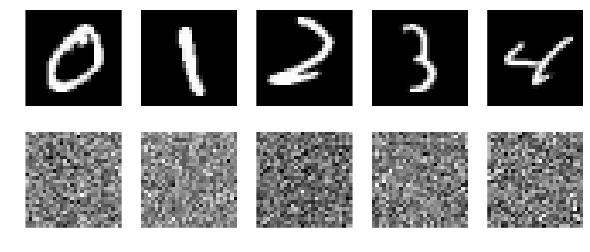

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
print(mnist.keys())
data = mnist['data'].reshape(-1, 1, 28, 28).astype('float32')
data /= np.max(data)
data = 0.001 + 0.998 * data
print(data.shape, data.dtype)

plt.figure(figsize=(10, 4))
gs = gridspec.GridSpec(2, 5)
matplotlib.rc('axes', **{'grid': False})

for i in range(5):
    ax = plt.subplot(gs[i])
    ax.imshow(data[i * 7000, 0], interpolation='none', cmap='gray')
    plt.axis('off')
    
for i in range(5, 10):
    ax = plt.subplot(gs[i])
    ax.imshow(np.random.randn(28, 28), interpolation='none', cmap='gray')
    plt.axis('off')